# Proyecto Semestral: Introducción a Redes Neuronales y Deep Learning

En este documento se aplica, con la mayor fidelidad posible lo abordado en el paper. El código esta separado en las siguientes secciones. 

## Imports

In [20]:
# ==========================================================
# IMPORTS
# ==========================================================
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, Sequence, Mapping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, Sequential

import matplotlib.pyplot as plt
import seaborn as sns


## Generación del dataset

* Indicadores técnicos
* Target(y) y splits temporales
* Escalado y construcción de ventanas 

In [21]:
def make_tech_indicators(
    data,
    price_col: str = "Close",
    high_col: str = "High",
    low_col: str = "Low",
    vol_col: str = "Volume",
    safe: bool = True,          # anti-fuga: shift(1) de todos los features
    reset_index: bool = True    # agrega columna Date en vez de dejar índice datetime
) -> pd.DataFrame:
    """
    Dada una serie temporal (pd.Series con precios o pd.DataFrame OHLCV),
    retorna un DataFrame con columnas: Date, Price, <indicadores...>.
    Todos los features quedan calculados solo con info hasta t
    (y si safe=True se desplazan 1 día para predecir t+1).
    """

    # ---------- Normalización de entrada ----------
    if isinstance(data, pd.Series):
        df = data.to_frame(name=price_col).copy()
    else:
        df = data.copy()

    if df.index.name is None:
        df.index.name = "Date"
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Asegura columnas esperadas y dtypes
    for c in [price_col, high_col, low_col, vol_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")
    if price_col not in df.columns:
        raise ValueError(f"Falta columna de precio '{price_col}'")

    has_hl = (high_col in df.columns) and (low_col in df.columns)
    has_vol = vol_col in df.columns

    # Alias locales
    close = df[price_col]
    high  = df[high_col] if has_hl else None
    low   = df[low_col]  if has_hl else None
    vol   = df[vol_col].replace(0, np.nan).astype("float64") if has_vol else None

    # ---------- Helpers internos ----------
    ema = lambda s, span: s.ewm(span=span, adjust=False).mean()

    def true_range():
        prev_close = close.shift(1)
        tr1 = (high - low) if has_hl else (close - close) * np.nan
        tr2 = (high - prev_close).abs() if has_hl else (close - prev_close).abs()
        tr3 = (low - prev_close).abs() if has_hl else (prev_close - close).abs()
        return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    def rsi(n=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        return (100 - (100 / (1 + rs))).fillna(50.0)

    def stochastic(n=14, d=3):
        if not has_hl:
            return pd.Series(np.nan, index=df.index), pd.Series(np.nan, index=df.index)
        low_n = low.rolling(n).min()
        high_n = high.rolling(n).max()
        den = (high_n - low_n).replace(0, np.nan)
        k = 100 * (close - low_n) / den
        dline = k.rolling(d).mean()
        return k, dline

    def bollinger(n=20, k=2):
        ma = close.rolling(n).mean()
        sd = close.rolling(n).std()
        upper, lower = ma + k*sd, ma - k*sd
        bw = (upper - lower) / ma
        den = (upper - lower).replace(0, np.nan)
        pb = (close - lower) / den
        return bw, pb

    def adx_block(n=14):
        if not has_hl:
            nan = pd.Series(np.nan, index=df.index)
            return nan, nan, nan, nan
        up_move = high.diff()
        down_move = -low.diff()
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
        tr = true_range()
        atr = tr.ewm(alpha=1/n, adjust=False).mean().replace(0, np.nan)
        plus_di = 100 * pd.Series(plus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        minus_di = 100 * pd.Series(minus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        den = (plus_di + minus_di).replace(0, np.nan)
        dx = 100 * (plus_di - minus_di).abs() / den
        adx = dx.ewm(alpha=1/n, adjust=False).mean()
        return atr, adx, plus_di, minus_di

    def obv():
        if not has_vol:
            return pd.Series(np.nan, index=df.index)
        return (np.sign(close.diff()).fillna(0) * vol.fillna(0)).cumsum()

    def mfi(n=14):
        if not (has_hl and has_vol):
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        mf = tp * vol.fillna(0.0)
        pos_flow = np.where(tp > tp.shift(1), mf, 0.0)
        neg_flow = np.where(tp < tp.shift(1), mf, 0.0)
        pos = pd.Series(pos_flow, index=df.index, dtype="float64").rolling(n).sum()
        neg = pd.Series(neg_flow, index=df.index, dtype="float64").rolling(n).sum()
        mfr = pos / neg.replace(0, np.nan)
        return (100 - (100 / (1 + mfr))).fillna(50.0)

    def cci(n=20):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        sma = tp.rolling(n).mean()
        mad = (tp - sma).abs().rolling(n).mean()
        return (tp - sma) / (0.015 * mad)

    def williams_r(n=14):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        hh = high.rolling(n).max()
        ll = low.rolling(n).min()
        denom = (hh - ll).replace(0, np.nan)
        return -100 * (hh - close) / denom

    # ---------- Cálculo de indicadores ----------
    out = pd.DataFrame(index=df.index)
    out["Price"] = close.astype("float64")

    out["Open"]   = df["Open"].astype("float64") if "Open" in df.columns else np.nan
    out["High"]   = high if has_hl else np.nan
    out["Low"]    = low if has_hl else np.nan
    out["Volume"] = df[vol_col] if has_vol else np.nan

    # Tendencia
    for n in [5, 10, 20, 50, 200]:
        out[f"SMA_{n}"] = close.rolling(n).mean()
    for n in [5, 10, 20, 50]:
        out[f"EMA_{n}"] = ema(close, n)

    macd = ema(close, 12) - ema(close, 26)
    macd_sig = ema(macd, 9)
    out["MACD"]        = macd
    out["MACD_signal"] = macd_sig
    out["MACD_hist"]   = macd - macd_sig

    # Momentum
    for h in [1, 5, 10]:
        out[f"ROC_{h}"] = (close - close.shift(h)) / close.shift(h)
        out[f"MOM_{h}"] = close - close.shift(h)
    out["RSI_14"] = rsi(14)

    # Volatilidad y bandas
    out["VOL_20"] = np.log(close / close.shift(1)).rolling(20).std()
    bw, pb = bollinger(20, 2)
    out["BB_BW"] = bw
    out["BB_PB"] = pb

    # Osciladores con H/L
    k, d = stochastic(14, 3)
    out["STOCH_K"]  = k
    out["STOCH_D"]  = d
    out["WILLR_14"] = williams_r(14)
    out["CCI_20"]   = cci(20)

    # Rango y dirección
    atr, adx, plus_di, minus_di = adx_block(14)
    out["ATR_14"]   = atr
    out["ADX_14"]   = adx
    out["PLUS_DI"]  = plus_di
    out["MINUS_DI"] = minus_di

    # Flujo / volumen
    out["OBV"]     = obv()
    out["MFI_14"]  = mfi(14)

    # Extras
    out["BIAS_12"] = (close - close.rolling(12).mean()) / close.rolling(12).mean()
    updays = (close.diff() > 0).astype(int)
    out["PSY_12"] = 100 * updays.rolling(12).mean()
    out["BBI"] = (
        close.rolling(3).mean()
        + close.rolling(6).mean()
        + close.rolling(12).mean()
        + close.rolling(24).mean()
    ) / 4.0

    # CHO (Chaikin Oscillator)
    if has_hl and has_vol:
        clv = ((close - low) - (high - close)) / (high - low)
        clv = clv.replace([np.inf, -np.inf], np.nan).fillna(0)
        adl = (clv * vol.fillna(0)).cumsum()
        out["CHO_3_10"] = ema(adl, 3) - ema(adl, 10)
    else:
        out["CHO_3_10"] = np.nan

    # MASS / WVAD / AR-BR / CR
    if has_hl:
        diff_hl = (high - low).abs()
        e1 = diff_hl.ewm(span=9, adjust=False).mean()
        e2 = e1.ewm(span=9, adjust=False).mean()
        ratio = e1 / e2.replace(0, np.nan)
        out["MASS_25"] = ratio.rolling(25).sum()
    else:
        out["MASS_25"] = np.nan

    if has_hl and has_vol:
        rng = (high - low).replace(0, np.nan)
        out["WVAD_24"] = (((close - df.get("Open", close)) / rng) * vol).rolling(24).sum()

        ar_num = (high - df.get("Open", close)).rolling(26).sum()
        ar_den = (df.get("Open", close) - low).rolling(26).sum().replace(0, np.nan)
        out["AR_26"] = 100 * ar_num / ar_den

        cp = close.shift(1)
        br_num = (high - cp).rolling(26).sum()
        br_den = (cp - low).rolling(26).sum().replace(0, np.nan)
        out["BR_26"] = 100 * br_num / br_den

        mid   = (high + low + 2*close) / 4
        mid_y = mid.shift(1)
        up    = (high - mid_y).clip(lower=0)
        down  = (mid_y - low).clip(lower=0)
        out["CR_26"] = 100 * up.rolling(26).sum() / down.rolling(26).sum().replace(0, np.nan)
    else:
        out["WVAD_24"] = np.nan
        out["AR_26"]   = np.nan
        out["BR_26"]   = np.nan
        out["CR_26"]   = np.nan

    # ---------- Anti-fuga ----------
    if safe:
        feat_cols = [c for c in out.columns if c != "Price"]
        out[feat_cols] = out[feat_cols].shift(1)

    # ---------- Limpieza ----------
    out = out.astype("float64")
    out = out.replace([np.inf, -np.inf], np.nan)
    out = out.dropna().copy()

    if reset_index:
        out = out.rename_axis("Date").reset_index()

    return out

@dataclass
class SplitDates:
    train_end: str  # fecha "YYYY-MM-DD" inclusive
    val_end: str    # fecha "YYYY-MM-DD" inclusive
    test_end: Optional[str] = None  # fecha "YYYY-MM-DD" inclusive, o None para resto
    
    @classmethod
    def from_ratios(cls, X_y, train_ratio: float, val_ratio: float):
        """
        Crea splits basados en proporciones del índice temporal de X_y.
        El índice DEBE ser un DatetimeIndex ordenado.

        train: desde inicio hasta train_ratio
        val:   desde train_ratio hasta train_ratio+val_ratio
        test:  desde (train+val) hasta el final
        """
        idx = X_y.index
        n = len(idx)
        
        # Posiciones en enteros
        
        pos_train_end = int(n*train_ratio) 
        pos_val_end = int(n*(train_ratio + val_ratio))
        
        pos_train_end = min(max(pos_train_end,0),n-1)
        pos_val_end = min(max(pos_val_end,0),n-1)
        
        # Convertir posiciones a fechas
        train_end_date = idx[pos_train_end].strftime("%Y-%m-%d")
        val_end_date = idx[pos_val_end].strftime("%Y-%m-%d")
        
        if pos_val_end == n-1:
            test_end_date = None
        else: 
            test_end_date = idx[-1].strftime("%Y-%m-%d")
            
        return cls(
                   train_end=train_end_date,
                   val_end=val_end_date,
                   test_end=test_end_date
        )


def build_xy(features_df: pd.DataFrame):
    """
    A partir de features técnicos devuelve:
    - X: todas las columnas de features (incluyendo Price).
    - y: Price_next = Price(t+1).
    """
    df = features_df.copy()
    if "Date" in df.columns: # Hacer de índice si está como columna
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()

    df["Price_next"] = df["Price"].shift(1 * -1)  # Price(t+1)
    df = df.dropna()

    y = df["Price_next"].astype(float)
    X = df.drop(columns=["Price_next"])

    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1] # columnas constantes
    if const_cols:
        X = X.drop(columns=const_cols)

    assert X.index.equals(y.index)
    return X, y



def time_splits(X: pd.DataFrame, y: pd.Series, dates: SplitDates):
    idx = X.index
    train = idx <= pd.to_datetime(dates.train_end)
    val   = (idx > pd.to_datetime(dates.train_end)) & (idx <= pd.to_datetime(dates.val_end))
    test  = idx > pd.to_datetime(dates.val_end) if dates.test_end is None else (
            (idx > pd.to_datetime(dates.val_end)) & (idx <= pd.to_datetime(dates.test_end)))
    return (X.loc[train], y.loc[train]), (X.loc[val], y.loc[val]), (X.loc[test], y.loc[test])


class TimeScaler:
    """
    MinMax para X, fit SOLO en train.
    """
    def __init__(self, feature_range=(0, 1)):
        self.scaler = MinMaxScaler(feature_range=feature_range)
        self.cols_: list[str] = []

    def fit(self, X_train: pd.DataFrame):
        self.scaler.fit(X_train.values)
        self.cols_ = list(X_train.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        missing = [c for c in self.cols_ if c not in X.columns]
        extra   = [c for c in X.columns if c not in self.cols_]
        assert not missing, f"Faltan columnas para transformar: {missing}"
        if extra:
            print(f"[AVISO] Columnas extra ignoradas en transform: {extra}")
        X2 = X[self.cols_].values
        return self.scaler.transform(X2)


class TimeScalerY:
    """
    MinMax para y, fit SOLO en train.
    """
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, y_train):
        self.scaler.fit(y_train.reshape(-1, 1))
        return self

    def transform(self, y):
        return self.scaler.transform(y.reshape(-1, 1)).flatten()

    def inverse(self, y_scaled):
        return self.scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()


def make_sequences(
    X_arr: np.ndarray,
    y_arr: np.ndarray,
    dates_arr: np.ndarray,
    lookback: int = 60,
):
    """
    Cada muestra: ventana [t-lookback+1 ... t] -> predice y[t].
    """
    n = len(y_arr)
    X_seq, y_seq, d_seq = [], [], []

    for t in range(lookback - 1, n):
        X_seq.append(X_arr[t - lookback + 1:t + 1, :])
        y_seq.append(y_arr[t])
        d_seq.append(dates_arr[t])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(d_seq),
    )


@dataclass
class LSTMPrepConfig:
    lookback: int = 5
    horizon: int = 1  # solo informativo
    selected_features: Optional[Sequence[str]] = None


def prepare_lstm_data(
    features_df: pd.DataFrame,
    split_dates: SplitDates,
    cfg: LSTMPrepConfig = LSTMPrepConfig(),
):
    """
    Construye secuencias escaladas para LSTM / modelos tabulares (flattened).
    """
    X, y = build_xy(features_df)

    if cfg.selected_features is not None:
        keep = [c for c in cfg.selected_features if c in X.columns]
        X = X[keep]
        assert list(X.columns) == keep

    (X_tr, y_tr), _, _ = time_splits(X, y, split_dates)

    scaler_x = TimeScaler().fit(X_tr)
    X_all_scaled = scaler_x.transform(X)

    y_all    = y.values.astype(np.float32)
    y_tr_arr = y_tr.values.astype(np.float32)

    scaler_y      = TimeScalerY().fit(y_tr_arr)
    y_all_scaled  = scaler_y.transform(y_all)
    dates_all     = X.index.to_numpy()

    X_seq, y_seq, d_seq = make_sequences(
        X_all_scaled,
        y_all_scaled,
        dates_all,
        lookback=cfg.lookback,
    )

    train_end_dt = pd.to_datetime(split_dates.train_end)
    val_end_dt   = pd.to_datetime(split_dates.val_end)
    test_end_dt  = pd.to_datetime(split_dates.test_end) if split_dates.test_end is not None else None

    train_mask = d_seq <= train_end_dt
    val_mask   = (d_seq > train_end_dt) & (d_seq <= val_end_dt)
    test_mask  = d_seq > val_end_dt if test_end_dt is None else (
                 (d_seq > val_end_dt) & (d_seq <= test_end_dt))

    Xtr_seq, ytr_seq = X_seq[train_mask], y_seq[train_mask]
    Xva_seq, yva_seq = X_seq[val_mask], y_seq[val_mask]
    Xte_seq, yte_seq = X_seq[test_mask], y_seq[test_mask]

    return {
        "X_train": Xtr_seq,
        "y_train": ytr_seq,
        "X_val":   Xva_seq,
        "y_val":   yva_seq,
        "X_test":  Xte_seq,
        "y_test":  yte_seq,
        "scaler_x":  scaler_x,
        "scaler_y":  scaler_y,
        "feature_cols": list(X.columns),
        "lookback": cfg.lookback,
        "horizon": 1,
        "dates_seq": d_seq,
    }


def prepare_tabular_from_lstm_prep(prep_dict):
    """
    Convierte tensores 3D (ventanas) a matrices 2D para sklearn.
    """
    def _flat(Xseq):
        n, L, f = Xseq.shape
        return Xseq.reshape(n, L * f)

    Xtr = _flat(prep_dict["X_train"])
    Xva = _flat(prep_dict["X_val"])
    Xte = _flat(prep_dict["X_test"])
    ytr = prep_dict["y_train"]
    yva = prep_dict["y_val"]
    yte = prep_dict["y_test"]
    return Xtr, ytr, Xva, yva, Xte, yte 

## Diseño de Algoritmo Genético

In [22]:
def evaluar_subset_TS(X: pd.DataFrame, y: pd.Series, mask: np.ndarray, n_splits=5) -> float:
    """
    Fitness del GA: R² medio (TimeSeriesSplit + Ridge) del subset de columnas.
    """
    sel_cols = X.columns[mask]
    if len(sel_cols) < 3:
        return -1e9

    Xs = X[sel_cols].values
    ys = y.values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    modelo = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("reg", Ridge(alpha=1.0))
    ])

    r2_list = []
    for tr_idx, te_idx in tscv.split(Xs):
        Xtr, Xte = Xs[tr_idx], Xs[te_idx]
        ytr, yte = ys[tr_idx], ys[te_idx]
        modelo.fit(Xtr, ytr)
        pr = modelo.predict(Xte)
        r2_list.append(r2_score(yte, pr))

    if not r2_list:
        return -1e9

    r2_mean = float(np.mean(r2_list))
    if not np.isfinite(r2_mean):
        r2_mean = -1e9
    return r2_mean


def _multipoint_crossover(p1: np.ndarray, p2: np.ndarray, n_points=2):
    L = len(p1)
    if L < 2:
        return p1.copy(), p2.copy()
    pts = np.sort(np.random.choice(np.arange(1, L), size=min(n_points, max(1, L-1)), replace=False))
    child1, child2 = p1.copy(), p2.copy()
    swap = False
    last = 0
    for pt in list(pts) + [L]:
        if swap:
            child1[last:pt], child2[last:pt] = p2[last:pt], p1[last:pt]
        last = pt
        swap = not swap
    return child1, child2


def _bitflip_mutation(ind: np.ndarray, p=0.003):
    flips = np.random.rand(ind.size) < p
    ind[flips] = ~ind[flips]
    return ind


def _ensure_min_features(ind: np.ndarray, kmin=3):
    on = ind.sum()
    if on < kmin:
        idx0 = np.where(~ind)[0]
        if idx0.size > 0:
            turn_on = np.random.choice(idx0, size=min(kmin-on, idx0.size), replace=False)
            ind[turn_on] = True
    return ind


@dataclass
class GAConfig:
    pop_size: int = 20
    p_crossover: float = 0.8
    p_mutation: float = 0.003
    generations: int = 100
    n_points_cx: int = 2
    elitism: int = 0
    min_features: int = 3
    n_splits_cv: int = 5
    random_state: int = 42


class GASelector:
    def __init__(self, X: pd.DataFrame, y: pd.Series, cfg: GAConfig):
        self.X = X
        self.y = y
        self.cfg = cfg
        np.random.seed(cfg.random_state)
        self.n_feat = X.shape[1]

        self.pop = np.random.rand(cfg.pop_size, self.n_feat) < 0.5
        for i in range(cfg.pop_size):
            self.pop[i] = _ensure_min_features(self.pop[i], cfg.min_features)

        self.history_best = []   # (gen, fitness, mask)
        self.history_scores = [] # fitness por generación

    def _fitness_all(self, pop):
        fits = np.zeros(pop.shape[0], dtype=float)
        for i, mask in enumerate(pop):
            fits[i] = evaluar_subset_TS(self.X, self.y, mask, n_splits=self.cfg.n_splits_cv)
        return fits

    def _roulette_select(self, fits, k):
        f = np.array(fits, dtype=float)
        f = f - f.min() + 1e-12
        p = f / f.sum() if f.sum() > 0 else np.ones_like(f) / len(f)
        idx = np.random.choice(len(f), size=k, replace=True, p=p)
        return idx

    def run(self):
        cfg = self.cfg
        pop = self.pop.copy()
        for gen in range(cfg.generations):
            fits = self._fitness_all(pop)
            self.history_scores.append(fits)

            ibest = int(np.argmax(fits))
            self.history_best.append((gen, float(fits[ibest]), pop[ibest].copy()))

            elite_idx = np.argsort(-fits)[:cfg.elitism]
            elites = pop[elite_idx].copy()

            parent_idx = self._roulette_select(fits, cfg.pop_size)
            parents = pop[parent_idx]

            next_pop = []
            for i in range(0, cfg.pop_size, 2):
                p1 = parents[i].copy()
                p2 = parents[i+1].copy() if i+1 < cfg.pop_size else parents[0].copy()
                if np.random.rand() < cfg.p_crossover:
                    c1, c2 = _multipoint_crossover(p1, p2, n_points=cfg.n_points_cx)
                else:
                    c1, c2 = p1, p2
                c1 = _bitflip_mutation(c1, cfg.p_mutation)
                c2 = _bitflip_mutation(c2, cfg.p_mutation)
                c1 = _ensure_min_features(c1, cfg.min_features)
                c2 = _ensure_min_features(c2, cfg.min_features)
                next_pop.append(c1); next_pop.append(c2)

            pop = np.array(next_pop[:cfg.pop_size], dtype=bool)

            if cfg.elitism > 0:
                repl_idx = np.random.choice(cfg.pop_size, size=cfg.elitism, replace=False)
                pop[repl_idx] = elites

        self.pop = pop
        return self

    def feature_importance_frequency(self):
        masks = [m for _, _, m in self.history_best]
        freq = np.sum(np.vstack(masks), axis=0).astype(int)
        imp = pd.Series(freq, index=self.X.columns, name="freq_best_generations").sort_values(ascending=False)
        return imp


def run_ga_feature_ranking(features_df: pd.DataFrame, cfg: GAConfig) -> pd.Series:
    """
    Ejecuta GA sobre un set de features y retorna un ranking (Series: feature -> frecuencia).
    """
    X_ga, y_ga = build_xy(features_df)
    ga = GASelector(X_ga, y_ga, cfg).run()
    ranking = ga.feature_importance_frequency()
    return ranking

## Construcción de modelos predictivos 

* LSTM
* NAIVE
* RandomForest
* PCA-SVR

Las métricas son en escala normalizada del target y.

In [ ]:
def make_lstm(input_shape, units=128, dropout=0.2, lr=1e-3):
    m = Sequential([
        layers.Input(shape=input_shape),

        # 1st LSTM layer
        layers.LSTM(
            units,
            return_sequences=True,
            activation="elu"
        ),
        layers.Dropout(dropout),

        # 2nd LSTM layer
        layers.LSTM(
            units,
            return_sequences=True,
            activation="elu"
        ),
        layers.Dropout(dropout),

        # 3rd LSTM layer
        layers.LSTM(
            units,
            return_sequences=False,
            activation="elu"
        ),
        layers.Dropout(dropout),

        layers.Dense(1)
    ])

    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return m



def eval_lstm_once(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Entrena UN LSTM y devuelve métricas en ESCALA NORMALIZADA.
    """
    tf.keras.utils.set_random_seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr = prep["X_train"], prep["y_train"]
    Xva, yva = prep["X_val"],   prep["y_val"]
    Xte, yte = prep["X_test"],  prep["y_test"]

    model = make_lstm(Xtr.shape[1:])
    es = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) # TODO hice un cambio aquí

    model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=512,
        callbacks=[es],
        verbose=0,
    )

    loss_tr, rmse_tr = model.evaluate(Xtr, ytr, verbose=0)
    loss_va, rmse_va = model.evaluate(Xva, yva, verbose=0)
    loss_te, rmse_te = model.evaluate(Xte, yte, verbose=0)

    return {
        "train_rmse": float(rmse_tr),
        "val_rmse":   float(rmse_va),
        "test_rmse":  float(rmse_te),
        "train_mse":  float(loss_tr),
        "val_mse":    float(loss_va),
        "test_mse":   float(loss_te),
    }


def eval_lstm_multirun(feature_list, splits, base_features_df, runs=3, lookback=5, seed0=123):
    res = [eval_lstm_once(feature_list, splits, base_features_df, lookback, seed0 + i) for i in range(runs)]
    df = pd.DataFrame(res)
    return {
        "val_mean":       df["val_rmse"].mean(),
        "val_std":        df["val_rmse"].std(ddof=1),
        "test_mean":      df["test_rmse"].mean(),
        "test_std":       df["test_rmse"].std(ddof=1),
        "val_mse_mean":   df["val_mse"].mean(),
        "val_mse_std":    df["val_mse"].std(ddof=1),
        "test_mse_mean":  df["test_mse"].mean(),
        "test_mse_std":   df["test_mse"].std(ddof=1),
        "runs": runs,
    }


def eval_naive_persistence(features_df: pd.DataFrame, splits: SplitDates):
    """
    Naive: predice Price_next[t] ≈ Price[t], usando MISMO escalado MinMax de y.
    Devuelve MSE en ESCALA NORMALIZADA.
    """
    X, y = build_xy(features_df)

    price_t = X["Price"].astype(float).values
    y_all   = y.values.astype(np.float32)

    idx = X.index
    train_mask = idx <= pd.to_datetime(splits.train_end)
    val_mask   = (idx > pd.to_datetime(splits.train_end)) & (idx <= pd.to_datetime(splits.val_end))
    test_mask  = idx > pd.to_datetime(splits.val_end) if splits.test_end is None else (
                 (idx > pd.to_datetime(splits.val_end)) & (idx <= pd.to_datetime(splits.test_end)))

    y_train  = y_all[train_mask]
    scaler_y = TimeScalerY().fit(y_train)

    y_scaled       = scaler_y.transform(y_all)
    price_t_scaled = scaler_y.transform(price_t)

    def _mse(mask):
        return mean_squared_error(y_scaled[mask], price_t_scaled[mask])

    return {
        "train_mse": _mse(train_mask),
        "val_mse":   _mse(val_mask),
        "test_mse":  _mse(test_mask),
    }


def eval_rf_baseline(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Random Forest sobre ventanas (flattened).
    MSE en ESCALA NORMALIZADA de y.
    """
    np.random.seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=seed,
    )
    rf.fit(Xtr, ytr)

    pr_tr = rf.predict(Xtr)
    pr_va = rf.predict(Xva)
    pr_te = rf.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }


def eval_pca_svr_baseline(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    PCA + SVR RBF. MSE en ESCALA NORMALIZADA de y.
    """
    np.random.seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    model = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=seed)),
        ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.01)),
    ])
    model.fit(Xtr, ytr)

    pr_tr = model.predict(Xtr)
    pr_va = model.predict(Xva)
    pr_te = model.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }

## Resultados Experimentales / Reportería

* Reporte por acción
* Reporte multi-acción

In [ ]:
def run_asset_report(
    csv_path: str,
    symbol: str,
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    ks: Sequence[int] = (5, 10, 20, 30),
    lookbacks: Sequence[int] = (5,10),
    runs: int = 3,
    ga_cfg: GAConfig = GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state=123,
    ),
    return_ranking: bool = False,
    train_ratio: float = 0.7,
    val_ratio: float = 0.1,
) -> pd.DataFrame:
    """
    Ejecuta TODO para una acción:
      - genera features
      - corre GA y obtiene ranking
      - evalúa Naive, RF(todas), PCA-SVR(todas), LSTM(todas), GA-LSTM(k) para cada lookback.

    Devuelve DataFrame con columnas:
      symbol, lookback, modelo, k, val_mse, test_mse,
      val_rmse_real, test_rmse_real
    """
    # 1) Cargar datos OHLCV y features
    df_ohlcv = pd.read_csv(csv_path).set_index("Date").sort_index()
    features = make_tech_indicators(
        df_ohlcv,
        safe=False,
        price_col="Close",
        high_col="High",
        low_col="Low",
        vol_col="Volume",
    )

    # Recorte opcional de ventana de tiempo [start_date, end_date]
    # -----------------------------------------------------------
    
    if (start_date is not None) or (end_date is not None):
        features["Date"] = pd.to_datetime(features["Date"])
        features = features.set_index("Date").sort_index()
        
        start = pd.to_datetime(start_date) if start_date is not None else features.index.min()
        end   = pd.to_datetime(end_date)   if end_date   is not None else features.index.max()
        features = features.loc[start:end].reset_index()
        
    # Rango de precios en train para pasar de MSE[0,1] a error real en dólares
    # (sobre ventana recortada, si es que se usó)
    # -----------------------------------------------------------
    X_y, y = build_xy(features)
    splits = SplitDates.from_ratios(X_y=X_y, train_ratio=train_ratio, val_ratio=val_ratio)
    
    (_, y_tr), _, _ = time_splits(X_y, y, splits)
    y_range = float(y_tr.max() - y_tr.min())

   # 2) GA -> ranking de features
    ranking = run_ga_feature_ranking(features, ga_cfg)
    feats_ordenados = list(ranking.index)
    all_features = list(X_y.columns)

    filas = []

    # Naive (no depende de lookback)
    naive_res = eval_naive_persistence(features, splits)

    for lookback in lookbacks:
        # Baselines con todas las features
        rf_all_res = eval_rf_baseline(all_features, splits, features, lookback=lookback)
        pca_all_res = eval_pca_svr_baseline(all_features, splits, features, lookback=lookback)
        lstm_all_res = eval_lstm_multirun(
            feature_list=all_features,
            splits=splits,
            base_features_df=features,
            runs=runs,
            lookback=lookback,
            seed0=200,
        )

        # Naive
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "Naive",
            "k": "-",
            "val_mse": naive_res["val_mse"],
            "test_mse": naive_res["test_mse"],
            # NUEVO: error promedio en dólares (RMSE real)
            "val_rmse_real":  (naive_res["val_mse"]  ** 0.5) * y_range,  # <<<
            "test_rmse_real": (naive_res["test_mse"] ** 0.5) * y_range,  # <<<
        })

        # RF / PCA-SVR / LSTM (todas)
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "RF (todas)",
            "k": "-",
            "val_mse": rf_all_res["val_mse"],
            "test_mse": rf_all_res["test_mse"],
            "val_rmse_real":  (rf_all_res["val_mse"]  ** 0.5) * y_range,  # <<<
            "test_rmse_real": (rf_all_res["test_mse"] ** 0.5) * y_range,  # <<<
        })
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "PCA-SVR (todas)",
            "k": "-",
            "val_mse": pca_all_res["val_mse"],
            "test_mse": pca_all_res["test_mse"],
            "val_rmse_real":  (pca_all_res["val_mse"]  ** 0.5) * y_range,  # <<<
            "test_rmse_real": (pca_all_res["test_mse"] ** 0.5) * y_range,  # <<<
        })
        filas.append({
            "symbol": symbol,
            "lookback": lookback,
            "modelo": "LSTM (todas)",
            "k": "-",
            "val_mse": lstm_all_res["val_mse_mean"],
            "test_mse": lstm_all_res["test_mse_mean"],
            "val_rmse_real":  lstm_all_res["val_mean"]  * y_range,
            "test_rmse_real": lstm_all_res["test_mean"] * y_range,
        })

        # GA-LSTM para distintos k
        for k in ks:
            selected = feats_ordenados[:k]
            lstm_ga_res = eval_lstm_multirun(
                feature_list=selected,
                splits=splits,
                base_features_df=features,
                runs=runs,
                lookback=lookback,
                seed0=123,
            )
            filas.append({
                "symbol": symbol,
                "lookback": lookback,
                "modelo": f"GA-LSTM (k={k})",
                "k": k,
                "val_mse": lstm_ga_res["val_mse_mean"],
                "test_mse": lstm_ga_res["test_mse_mean"],
                "val_rmse_real":  lstm_ga_res["val_mean"]  * y_range,
                "test_rmse_real": lstm_ga_res["test_mean"] * y_range,
            })

    reporte = pd.DataFrame(filas)
    
    if return_ranking: 
        return reporte, ranking
    
    return reporte



def run_multi_asset_report(
    symbol_to_path: Mapping[str, str],
    start_date: pd.Timestamp,
    end_date: pd.Timestamp,
    ks: Sequence[int] = (5, 10, 20, 30),
    lookbacks: Sequence[int] = (5,),
    runs: int = 3,
    ga_cfg: GAConfig = GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state=123,
    ),
    train_ratio: float = 0.7,
    val_ratio: float = 0.1
) -> pd.DataFrame:
    """
    Loop sobre varias acciones y concatena los reportes.
    symbol_to_path: dict {ticker: ruta_csv}
    """
    reports = []
    for symbol, path in symbol_to_path.items():
        rep = run_asset_report(
            csv_path=path,
            symbol=symbol,
            ks=ks,
            lookbacks=lookbacks,
            runs=runs,
            ga_cfg=ga_cfg,
            start_date=start_date,
            end_date=end_date,
            train_ratio=train_ratio,
            val_ratio=val_ratio,
        )
        reports.append(rep)

    return pd.concat(reports, ignore_index=True)

def build_symbol_reports(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    reports = {}
    for sym, g in df.groupby("symbol"):
        # Ordenado bonito y con índice compuesto
        g2 = (
            g.sort_values(["lookback", "modelo"])
             .set_index(["lookback", "modelo"])
        )
        reports[sym] = g2
    return reports


# Resultados

In [25]:
# Una sola acción
report_aapl, ranking_aapl = run_asset_report(
    csv_path="Dataset/Stocks/aapl.us.txt",
    symbol="AAPL",
    ks=(5, 10, 20, 30),
    lookbacks=[5],   # por ejemplo probar lookback 5 zy 10
    runs=3,
    return_ranking = True,
    start_date="2007-01-01",
    end_date="2009-12-31"
)

2025-11-16 12:22:58.098148: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [26]:

df = report_aapl.copy()


tabla_ordenada = df.sort_values(["lookback"]).reset_index(drop=True)

tabla_ordenada = tabla_ordenada.pivot_table(
    index="modelo",
    columns="lookback",
    values=["val_mse", "test_mse", "val_rmse_real", "test_rmse_real"],
    observed=True
)

tabla_ordenada.columns = [
    f"{metric}_{lookback}"
    for metric, lookback in tabla_ordenada.columns
]
print(tabla_ordenada)


                 test_mse_5  test_rmse_real_5  val_mse_5  val_rmse_real_5
modelo                                                                   
GA-LSTM (k=10)     0.002950          0.846102   0.001545         0.612291
GA-LSTM (k=20)     0.004278          1.018890   0.001338         0.569844
GA-LSTM (k=30)     0.005559          1.161355   0.001399         0.582617
GA-LSTM (k=5)      0.002347          0.754616   0.001483         0.599922
LSTM (todas)       0.005641          1.169941   0.001723         0.646518
Naive              0.000532          0.359265   0.000541         0.362397
PCA-SVR (todas)    0.024573          2.441796   0.001763         0.654108
RF (todas)         0.004253          1.015882   0.000682         0.406869


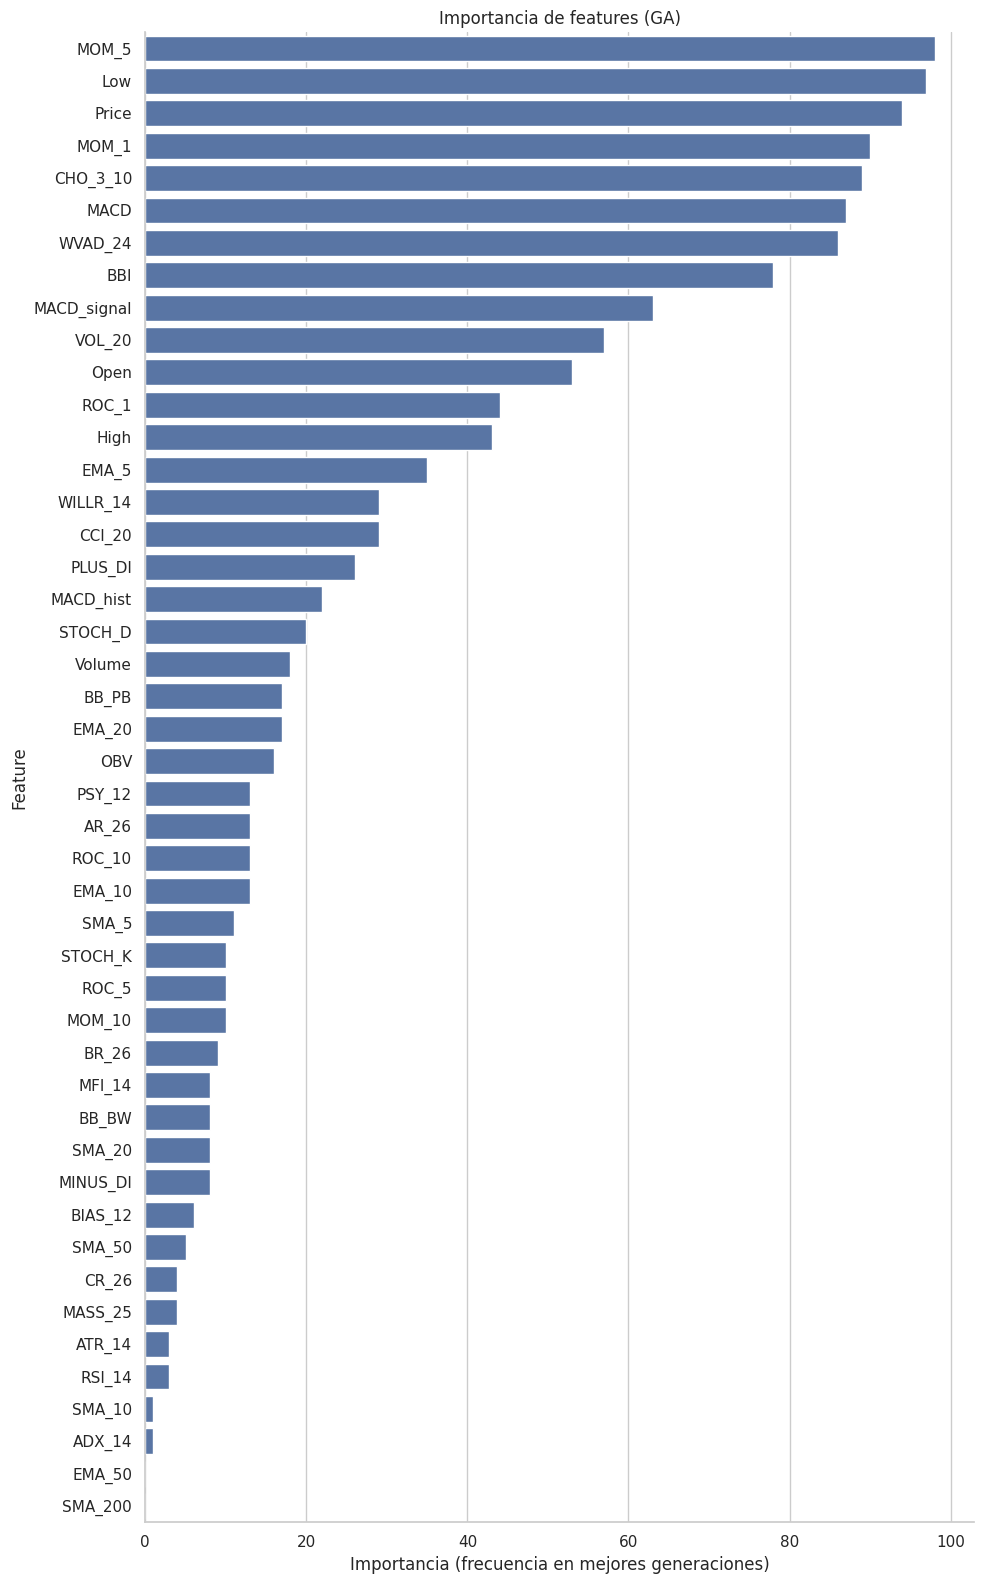

In [27]:


top_n = 46 # ajusta a gusto
plot_df = ranking_aapl.sort_values(ascending=False).head(top_n).reset_index()
plot_df.columns = ["feature", "importance"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, max(4, int(top_n*0.35))))
ax = sns.barplot(data=plot_df, x="importance", y="feature")
ax.set(
    title="Importancia de features (GA)",
    xlabel="Importancia (frecuencia en mejores generaciones)",
    ylabel="Feature"
)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
symbol_to_path = {
    "AAPL": "Dataset/Stocks/aapl.us.txt",
    "MSFT": "Dataset/Stocks/msft.us.txt",
    "SP500": "Dataset/ETFs/spy.us.txt",
}

df = run_multi_asset_report(
    symbol_to_path=symbol_to_path,
    start_date="2007-01-01",
    end_date="2009-12-31",
    ks=(5, 10, 20, 30),
    lookbacks=(5,),
    runs=3,
    ga_cfg=GAConfig(
        pop_size=100,
        p_crossover=0.8,
        p_mutation=0.003,
        generations=100,
        n_points_cx=4,
        elitism=0,
        min_features=3,
        n_splits_cv=5,
        random_state=123,
    ),
    train_ratio=0.7,
    val_ratio=0.1,
)


def build_symbol_reports(df: pd.DataFrame) -> dict[str, pd.DataFrame]:
    """
    Devuelve un dict {symbol: df_symbol} donde df_symbol tiene índice (lookback, modelo)
    y está ordenado de forma consistente.
    """
    reports = {}
    for sym, g in df.groupby("symbol"):
        g2 = (
            g.sort_values(["lookback", "modelo"])
             .set_index(["lookback", "modelo"])
        )
        reports[sym] = g2
    return reports


reports = build_symbol_reports(df)

# Impresión formateada usando sólo build_symbol_reports
for sym, df_sym in reports.items():
    print(f"\n===== {sym} =====")
    # df_sym tiene índice MultiIndex: (lookback, modelo)
    for (lookback, modelo), row in df_sym.iterrows():
        print(
            f"Modelo: {modelo:15s} | "
            f"lookback={int(lookback)} | "
            f"val: {row['val_rmse_real']:.4f} USD "
            f"(MSE={row['val_mse']:.6f}) | "
            f"test: {row['test_rmse_real']:.4f} USD "
            f"(MSE={row['test_mse']:ent.6f})"
        )



===== AAPL =====
Modelo: GA-LSTM (k=10)  | lookback=5 | val: 0.6123 USD (MSE=0.001545) | test: 0.8461 USD (MSE=0.002950)
Modelo: GA-LSTM (k=20)  | lookback=5 | val: 0.5698 USD (MSE=0.001338) | test: 1.0189 USD (MSE=0.004278)
Modelo: GA-LSTM (k=30)  | lookback=5 | val: 0.5826 USD (MSE=0.001399) | test: 1.1614 USD (MSE=0.005559)
Modelo: GA-LSTM (k=5)   | lookback=5 | val: 0.5999 USD (MSE=0.001483) | test: 0.7546 USD (MSE=0.002347)
Modelo: LSTM (todas)    | lookback=5 | val: 0.6465 USD (MSE=0.001723) | test: 1.1699 USD (MSE=0.005641)
Modelo: Naive           | lookback=5 | val: 0.3624 USD (MSE=0.000541) | test: 0.3593 USD (MSE=0.000532)
Modelo: PCA-SVR (todas) | lookback=5 | val: 0.6541 USD (MSE=0.001763) | test: 2.4418 USD (MSE=0.024573)
Modelo: RF (todas)      | lookback=5 | val: 0.4069 USD (MSE=0.000682) | test: 1.0159 USD (MSE=0.004253)

===== MSFT =====
Modelo: GA-LSTM (k=10)  | lookback=5 | val: 1.0820 USD (MSE=0.004179) | test: 5.5085 USD (MSE=0.108307)
Modelo: GA-LSTM (k=20)  | lo